In [158]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import plotly.io as pio
import plotly.express as px

import plotly.graph_objs as go
import seaborn as sns


from walmart_utils.download import download_dataset
from walmart_utils.merge_data import merge_data, dedupe
from walmart_utils.feature_engineering import (
    add_calendar_features, sum_markdown, add_holiday,
    add_memory_feature
)
from walmart_utils.exploratory_analysis import view_data_horizon
from walmart_utils.pipeline import GlobalPipeline
from walmart_utils.models import models
from walmart_utils.training import evaluate_models, plot_errors

# !poetry add statsmodels

## **1. Data Preprocessing**

In [159]:
zip_path = "./walmart-recruiting-store-sales-forecasting.zip"
extract_dir = "./walmart_dataset"

In [160]:
features_df, stores_df, test_df, train_df = download_dataset()

El archivo ./walmart-recruiting-store-sales-forecasting.zip no existe.
El archivo ./walmart_dataset/features.csv.zip no existe.
El archivo ./walmart_dataset/sampleSubmission.csv.zip no existe.
El archivo ./walmart_dataset/test.csv.zip no existe.
El archivo ./walmart_dataset/train.csv.zip no existe.
dataset descargado con éxito :)
dataset formateado :)


In [161]:
print("Train shape: ", train_df.shape)
print("Test shape: ", test_df.shape)
print("Feaures shape: ", features_df.shape)
print("Stores shape: ", stores_df.shape)

Train shape:  (421570, 5)
Test shape:  (115064, 5)
Feaures shape:  (8190, 12)
Stores shape:  (45, 3)


In [162]:
def drop_unnused_Store_Dept_combinations(train_df, test_df):
    ''' 
    hay combinaciones de tiendas y departamentos que no tienen ventas, y 
    ademas no existen en el dataset de test, así que no tiene sentido usarlos en el train"
    '''
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()
    train_df_copy['Store_Dept'] = train_df_copy['Store'].astype(str) + '_' + train_df_copy['Dept'].astype(str)
    test_df_copy['Store_Dept'] = test_df_copy['Store'].astype(str) + '_' + test_df_copy['Dept'].astype(str)
    test_unique_Store_Dept = test_df_copy["Store_Dept"].unique()
    return train_df_copy[train_df_copy["Store_Dept"].isin(test_unique_Store_Dept)].drop("Store_Dept",axis=1)

In [163]:
# train_df = drop_unnused_Store_Dept_combinations(train_df, test_df)

In [164]:
train_df['IsTrain'] = True
test_df['IsTrain'] = False

In [165]:
train_df[(train_df["Store"]==1) & (train_df["Dept"]==1)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,IsTrain
0,1,1,2010-02-05,24924.50,False,True
1,1,1,2010-02-12,46039.49,True,True
2,1,1,2010-02-19,41595.55,False,True
3,1,1,2010-02-26,19403.54,False,True
4,1,1,2010-03-05,21827.90,False,True
...,...,...,...,...,...,...
138,1,1,2012-09-28,18947.81,False,True
139,1,1,2012-10-05,21904.47,False,True
140,1,1,2012-10-12,22764.01,False,True
141,1,1,2012-10-19,24185.27,False,True


In [166]:
def features_info():
    display("Información de features: (^◕.◕^) 😼")
    display(features_df.info())
    display("Información de stores: ( •̀ ω •́ )✧ 🫡")
    display(stores_df.info())
    display("Información de train: ヾ(•ω•`)o 🥺")
    display(train_df.info())
    display("Información de test: ╰(*°▽°*)╯ 🫣")
    display(test_df.info())
    return "all!"

In [167]:
features_info()

'Información de features: (^◕.◕^) 😼'

<class 'pandas.core.frame.DataFrame'>
Index: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 775.8 KB


None

'Información de stores: ( •̀ ω •́ )✧ 🫡'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

'Información de train: ヾ(•ω•`)o 🥺'

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   IsTrain       421570 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(1), int64(2)
memory usage: 16.9 MB


None

'Información de test: ╰(*°▽°*)╯ 🫣'

<class 'pandas.core.frame.DataFrame'>
Index: 115064 entries, 0 to 115063
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         115064 non-null  int64         
 1   Dept          115064 non-null  int64         
 2   Date          115064 non-null  datetime64[ns]
 3   IsHoliday     115064 non-null  bool          
 4   Weekly_Sales  115064 non-null  int64         
 5   IsTrain       115064 non-null  bool          
dtypes: bool(2), datetime64[ns](1), int64(3)
memory usage: 4.6 MB


None

'all!'

Merging stores and features data frames with train and test data with pandas merge.

In [168]:
data = merge_data(train_df, test_df, stores_df, features_df)

In [169]:
data = data.drop(labels="IsHoliday_y", axis=1)
data["IsHoliday"] = data["IsHoliday_x"]
data = data.drop(labels="IsHoliday_x", axis=1)

In [170]:
data.head(3)

,Store,Dept,Date,Weekly_Sales,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-02-05,24924.50,True,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
5747,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
6829,1,1,2010-02-19,41595.55,True,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


Converting boolean features to 0s and 1s

In [171]:
lb_IsHoliday = LabelBinarizer()
data["IsHoliday"] = lb_IsHoliday.fit_transform(data["IsHoliday"])

In [172]:
data["IsHoliday"].head(5)

0        0
5747     1
6829     0
11698    0
12681    0
Name: IsHoliday, dtype: int32

Checking for missing/nan values

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536634 entries, 0 to 536633
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         536634 non-null  int64         
 1   Dept          536634 non-null  int64         
 2   Date          536634 non-null  datetime64[ns]
 3   Weekly_Sales  536634 non-null  float64       
 4   IsTrain       536634 non-null  bool          
 5   Type          536634 non-null  object        
 6   Size          536634 non-null  int64         
 7   Temperature   536634 non-null  float64       
 8   Fuel_Price    536634 non-null  float64       
 9   MarkDown1     265596 non-null  float64       
 10  MarkDown2     197685 non-null  float64       
 11  MarkDown3     242326 non-null  float64       
 12  MarkDown4     237143 non-null  float64       
 13  MarkDown5     266496 non-null  float64       
 14  CPI           498472 non-null  float64       
 15  Unemployment  498472 n

The only features with missing values are MarkDown(1–5) which are anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011 and is not available for all stores all the time. Any missing value is marked with an NA. I have replaced the nan values in these columns with 0.

In [174]:
inputer_zero = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
inputer_zero.fit(data[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]])


SimpleImputer(fill_value=0, strategy='constant')

In [175]:
data[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]] = inputer_zero.transform(data[["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]])

The cleaned data looks like this —

## **Feature Engineering**

From the Date column, I have extracted DayOfMonth, Month, Year, DayOfWeek, WeekOfYear, and Quarter and dropped the Date column

In [176]:
data = add_calendar_features(data)

Created a new column called MarkDown which is the sum of all MarkDown(1–5) columns after which those 5 columns were dropped

In [177]:
#data = sum_markdown(data=data, colums=["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4","MarkDown5"])

In [178]:
#data["MarkDown"].sample(5)

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

In [179]:
super_bowl = ["12-02-10", "11-02-11", "10-02-12", "08-02-13"]
labor_day =  ["10-09-10", "09-09-11", "07-09-12", "06-09-13"]
thanks_giving = ["26-11-10", "25-11-11", "23-11-12", "29-11-13"]
christmas = ["31-12-10", "30-12-11", "28-12-12", "27-12-13"]
holiday_list  = super_bowl + labor_day + thanks_giving + christmas
holiday_list[:5]

['12-02-10', '11-02-11', '10-02-12', '08-02-13', '10-09-10']

In [180]:
data = add_holiday(data, holiday_list )

In [181]:
data.describe()

,Store,Dept,Date,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,month,day_of_month,week_of_year,quarter,year
count,536634.000000,536634.000000,536634,536634.000000,536634.00000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,536634.000000,498472.000000,498472.000000,536634.000000,536634.000000,536634.000000,536634.0,536634.000000,536634.000000
mean,22.208621,44.277301,2011-11-01 13:33:31.458088704,12554.588392,136678.55096,58.771762,3.408310,3681.287709,1292.745138,838.971725,1489.918846,2147.337557,172.090481,7.791888,0.071909,6.295203,30.422478,25.231581,2.429537,2011.354241
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000,34875.00000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.000000,-185.170000,126.064000,3.684000,0.000000,1.000000,28.000000,1.0,1.000000,2010.000000
25%,11.000000,18.000000,2010-12-17 00:00:00,49.852500,93638.00000,45.250000,3.041000,0.000000,0.000000,0.000000,0.000000,0.000000,132.521867,6.623000,0.000000,3.000000,30.000000,13.0,1.000000,2010.000000
50%,22.000000,37.000000,2011-11-04 00:00:00,4118.755000,140167.00000,60.060000,3.523000,0.000000,0.000000,0.000000,0.000000,0.000000,182.442420,7.795000,0.000000,6.000000,31.000000,24.0,2.000000,2011.000000
75%,33.000000,74.000000,2012-09-14 00:00:00,15497.417500,202505.00000,73.230000,3.744000,5046.740000,118.730000,29.140000,906.450000,2852.190000,213.748126,8.549000,0.000000,9.000000,31.000000,37.0,3.000000,2012.000000
max,45.000000,99.000000,2013-07-26 00:00:00,693099.360000,219622.00000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,1.000000,12.000000,31.000000,52.0,4.000000,2013.000000
std,12.790580,30.527358,NaN,21171.249456,61007.71180,18.678716,0.430861,7593.883000,5714.136207,7860.456173,4865.593575,9789.902903,39.542149,1.865076,0.258338,3.333808,0.827435,14.554119,1.092347,1.040218


In [182]:
data = add_memory_feature(data_df=data, target= "Weekly_Sales")

Adding memory variable 😸: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.75it/s]


In [183]:
data = data[data["Date"] >= "2011-03-18"]

In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366597 entries, 170297 to 536633
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        366597 non-null  int64         
 1   Dept                         366597 non-null  int64         
 2   Date                         366597 non-null  datetime64[ns]
 3   Weekly_Sales                 366597 non-null  float64       
 4   IsTrain                      366597 non-null  bool          
 5   Type                         366597 non-null  object        
 6   Size                         366597 non-null  int64         
 7   Temperature                  366597 non-null  float64       
 8   Fuel_Price                   366597 non-null  float64       
 9   MarkDown1                    366597 non-null  float64       
 10  MarkDown2                    366597 non-null  float64       
 11  MarkDown3                 

In [185]:
view_data_horizon(data, target="Weekly_Sales", store=1, dept=18)

In [186]:
test_df["Date"].max()

Timestamp('2013-07-26 00:00:00')

In [187]:
missing_data = data["l_0_w_3_max_Weekly_Sales"].isna()
data[missing_data]

,Store,Dept,Date,Weekly_Sales,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,...,l_3_w_3_median_Weekly_Sales,l_3_w_3_std_Weekly_Sales,l_3_w_3_max_Weekly_Sales,l_3_w_3_min_Weekly_Sales,l_3_w_4_sum_Weekly_Sales,l_3_w_4_mean_Weekly_Sales,l_3_w_4_median_Weekly_Sales,l_3_w_4_std_Weekly_Sales,l_3_w_4_max_Weekly_Sales,l_3_w_4_min_Weekly_Sales
170929,1,18,2011-03-18,296.03,True,A,151315,62.76,3.488,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
173219,1,18,2011-03-25,701.98,True,A,151315,69.97,3.473,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178149,1,18,2011-04-01,1550.18,True,A,151315,59.17,3.524,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181552,1,18,2011-04-08,2133.87,True,A,151315,67.84,3.622,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181817,1,18,2011-04-15,4304.00,True,A,151315,71.27,3.743,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401035,45,96,2012-09-14,2.94,True,B,118221,67.87,3.948,11407.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170901,45,98,2011-03-18,693.82,True,B,118221,46.66,3.631,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
175516,45,98,2011-03-25,1101.26,True,B,118221,41.76,3.625,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
176000,45,98,2011-04-01,991.32,True,B,118221,37.27,3.638,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Exploratory data analysis**

Mapa de calor de la matriz de correlación

In [188]:
numeric_columns = [
    'Store', 'Dept', 'Weekly_Sales', 'Size', 'Temperature',
    'Fuel_Price', 'CPI', 'Unemployment', 'IsHoliday', 'month',
    'day_of_month', 'week_of_year', 'quarter', 'year', #'MarkDown'
]
data[numeric_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 366597 entries, 170297 to 536633
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         366597 non-null  int64  
 1   Dept          366597 non-null  int64  
 2   Weekly_Sales  366597 non-null  float64
 3   Size          366597 non-null  int64  
 4   Temperature   366597 non-null  float64
 5   Fuel_Price    366597 non-null  float64
 6   CPI           328435 non-null  float64
 7   Unemployment  328435 non-null  float64
 8   IsHoliday     366597 non-null  int32  
 9   month         366597 non-null  int32  
 10  day_of_month  366597 non-null  int32  
 11  week_of_year  366597 non-null  UInt32 
 12  quarter       366597 non-null  int32  
 13  year          366597 non-null  int32  
dtypes: UInt32(1), float64(5), int32(5), int64(3)
memory usage: 33.9 MB


In [189]:
print("Fecha de inicio de train", train_df["Date"].min())
print("Fecha de fin de train",train_df["Date"].max())

print("Fecha de inicio de test", test_df["Date"].min())
print("Fecha de fin de test",test_df["Date"].max())

Fecha de inicio de train 2010-02-05 00:00:00
Fecha de fin de train 2012-10-26 00:00:00
Fecha de inicio de test 2012-11-02 00:00:00
Fecha de fin de test 2013-07-26 00:00:00


In [190]:
missing_data = data[data['CPI'].isna() | data['Unemployment'].isna()]

In [191]:
view_data_horizon(data, target="CPI")

In [192]:
view_data_horizon(data, target="Unemployment")

In [193]:
view_data_horizon(data, target="Temperature")

In [194]:
view_data_horizon(data, target="Weekly_Sales")

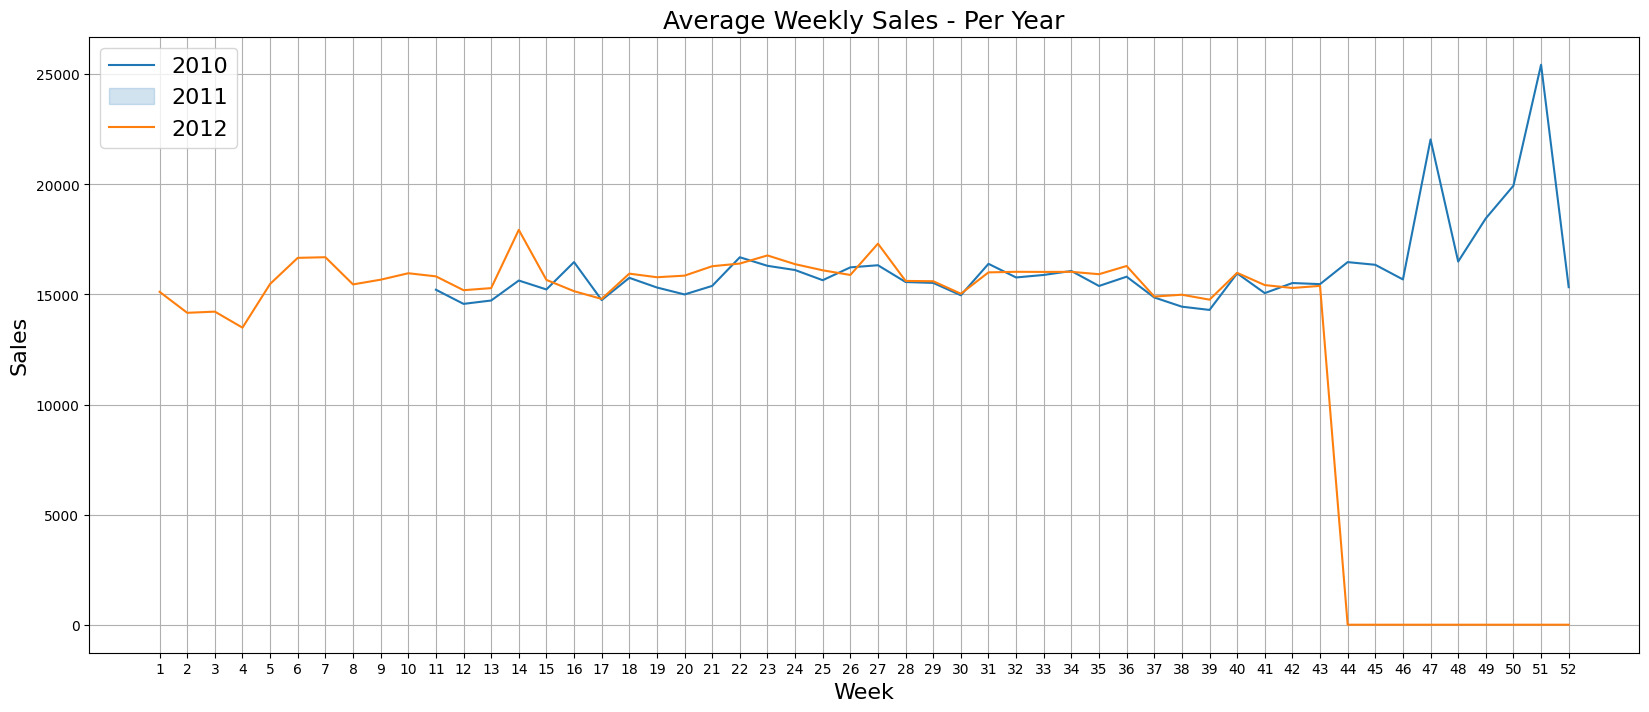

In [195]:
weekly_sales_2010 = data[data.year==2010]['Weekly_Sales'].groupby(data['week_of_year']).mean()
weekly_sales_2011 = data[data.year==2011]['Weekly_Sales'].groupby(data['week_of_year']).mean()
weekly_sales_2012 = data[data.year==2012]['Weekly_Sales'].groupby(data['week_of_year']).mean()

plt.figure(figsize=(20,8))

sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)

plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize=16)
plt.title('Average Weekly Sales - Per Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Week', fontsize=16)
plt.show()


In [196]:
corr_df = data[numeric_columns].corr(method="pearson")

fig = px.imshow(
    corr_df.values,
    x=numeric_columns,
    y=numeric_columns,
)
fig.update_xaxes(side="top")
fig.show()

In [197]:
#inputar valores faltantes
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366597 entries, 170297 to 536633
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        366597 non-null  int64         
 1   Dept                         366597 non-null  int64         
 2   Date                         366597 non-null  datetime64[ns]
 3   Weekly_Sales                 366597 non-null  float64       
 4   IsTrain                      366597 non-null  bool          
 5   Type                         366597 non-null  object        
 6   Size                         366597 non-null  int64         
 7   Temperature                  366597 non-null  float64       
 8   Fuel_Price                   366597 non-null  float64       
 9   MarkDown1                    366597 non-null  float64       
 10  MarkDown2                    366597 non-null  float64       
 11  MarkDown3                 

In [198]:
column = "CPI"
isnull = data[column].isnull().value_counts()
isnull.values / len(data[column])
pd.Series(isnull.values / len(data[column]), index=["No null", "Null"])

No null    0.895902
Null       0.104098
dtype: float64

In [199]:
column = "Unemployment"
isnull = data[column].isnull().value_counts()
isnull.values / len(data[column])
pd.Series(isnull.values / len(data[column]), index=["No null", "Null"])

No null    0.895902
Null       0.104098
dtype: float64

In [200]:
data.loc[:,"CPI"] = data["CPI"].ffill()

In [201]:
view_data_horizon(data, target="CPI")

In [202]:
view_data_horizon(data, target="Unemployment")

In [203]:
data.loc[:,"Unemployment"] = data["Unemployment"].ffill()

In [204]:
view_data_horizon(data, target="Unemployment")

In [205]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 366597 entries, 170297 to 536633
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        366597 non-null  int64         
 1   Dept                         366597 non-null  int64         
 2   Date                         366597 non-null  datetime64[ns]
 3   Weekly_Sales                 366597 non-null  float64       
 4   IsTrain                      366597 non-null  bool          
 5   Type                         366597 non-null  object        
 6   Size                         366597 non-null  int64         
 7   Temperature                  366597 non-null  float64       
 8   Fuel_Price                   366597 non-null  float64       
 9   MarkDown1                    366597 non-null  float64       
 10  MarkDown2                    366597 non-null  float64       
 11  MarkDown3                 

In [206]:
data = data.copy()  
data.dropna(inplace=True)

In [207]:
view_data_horizon(data,45,77)

## **3. Preparing to Train Models**

In [208]:
data.sort_values(by=["Date"], ascending=True, inplace=True)

Splitting into train and validation sets (75–25 split)

In [209]:
print("Fecha de inicio de train", train_df["Date"].min())
print("Fecha de fin de train",train_df["Date"].max())


Fecha de inicio de train 2010-02-05 00:00:00
Fecha de fin de train 2012-10-26 00:00:00


In [210]:
print("Fecha de inicio de test", test_df["Date"].min())
print("Fecha de fin de test",test_df["Date"].max())

Fecha de inicio de test 2012-11-02 00:00:00
Fecha de fin de test 2013-07-26 00:00:00


In [211]:
train_data = data[ data["Date"] <=  "2012-10-26"]
test_df = data[ data["Date"] >  "2012-10-26"]

Identifying numeric and categorical columns

In [212]:
def num_cat_cols(data):
    numeric_cols = data.select_dtypes(include=['int64', 'int32','UInt32', 'float64']).columns.tolist()
    categorical_cols = data.select_dtypes('object').columns.tolist()
    return numeric_cols, categorical_cols

In [213]:
numeric_cols, categorical_cols  = num_cat_cols(data.drop(["Date", "Store", "Weekly_Sales", "CPI", "Unemployment"], axis=1))

display(numeric_cols)
display(categorical_cols)

['Dept',
 'Size',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'IsHoliday',
 'month',
 'day_of_month',
 'week_of_year',
 'quarter',
 'year',
 'lag_0_Weekly_Sales',
 'l_0_w_3_sum_Weekly_Sales',
 'l_0_w_3_mean_Weekly_Sales',
 'l_0_w_3_median_Weekly_Sales',
 'l_0_w_3_std_Weekly_Sales',
 'l_0_w_3_max_Weekly_Sales',
 'l_0_w_3_min_Weekly_Sales',
 'l_0_w_4_sum_Weekly_Sales',
 'l_0_w_4_mean_Weekly_Sales',
 'l_0_w_4_median_Weekly_Sales',
 'l_0_w_4_std_Weekly_Sales',
 'l_0_w_4_max_Weekly_Sales',
 'l_0_w_4_min_Weekly_Sales',
 'lag_1_Weekly_Sales',
 'l_1_w_3_sum_Weekly_Sales',
 'l_1_w_3_mean_Weekly_Sales',
 'l_1_w_3_median_Weekly_Sales',
 'l_1_w_3_std_Weekly_Sales',
 'l_1_w_3_max_Weekly_Sales',
 'l_1_w_3_min_Weekly_Sales',
 'l_1_w_4_sum_Weekly_Sales',
 'l_1_w_4_mean_Weekly_Sales',
 'l_1_w_4_median_Weekly_Sales',
 'l_1_w_4_std_Weekly_Sales',
 'l_1_w_4_max_Weekly_Sales',
 'l_1_w_4_min_Weekly_Sales',
 'lag_2_Weekly_Sales',
 'l_2_w_3_sum_Weekly_

['Type']

In [214]:
numeric_cols.remove("Dept")
numeric_cols.remove("month")

categorical_cols.append("Dept")
categorical_cols.append("month")

display(numeric_cols)
display(categorical_cols)

['Size',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'IsHoliday',
 'day_of_month',
 'week_of_year',
 'quarter',
 'year',
 'lag_0_Weekly_Sales',
 'l_0_w_3_sum_Weekly_Sales',
 'l_0_w_3_mean_Weekly_Sales',
 'l_0_w_3_median_Weekly_Sales',
 'l_0_w_3_std_Weekly_Sales',
 'l_0_w_3_max_Weekly_Sales',
 'l_0_w_3_min_Weekly_Sales',
 'l_0_w_4_sum_Weekly_Sales',
 'l_0_w_4_mean_Weekly_Sales',
 'l_0_w_4_median_Weekly_Sales',
 'l_0_w_4_std_Weekly_Sales',
 'l_0_w_4_max_Weekly_Sales',
 'l_0_w_4_min_Weekly_Sales',
 'lag_1_Weekly_Sales',
 'l_1_w_3_sum_Weekly_Sales',
 'l_1_w_3_mean_Weekly_Sales',
 'l_1_w_3_median_Weekly_Sales',
 'l_1_w_3_std_Weekly_Sales',
 'l_1_w_3_max_Weekly_Sales',
 'l_1_w_3_min_Weekly_Sales',
 'l_1_w_4_sum_Weekly_Sales',
 'l_1_w_4_mean_Weekly_Sales',
 'l_1_w_4_median_Weekly_Sales',
 'l_1_w_4_std_Weekly_Sales',
 'l_1_w_4_max_Weekly_Sales',
 'l_1_w_4_min_Weekly_Sales',
 'lag_2_Weekly_Sales',
 'l_2_w_3_sum_Weekly_Sales',
 'l_2_w_3_m

['Type', 'Dept', 'month']

In [215]:
input_cols = numeric_cols + categorical_cols
target_col = ['Weekly_Sales']

Imputation, Scaling, and Encoding

In [216]:
pipeline = GlobalPipeline(numeric_cols, categorical_cols)
pipeline.fit(train_data[input_cols] )

In [217]:
preprocessor = pipeline.get_preprocessor()
preprocessor

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['Size', 'Temperature', 'Fuel_Price',
                                  'MarkDown1', 'MarkDown2', 'MarkDown3',
                                  'MarkDown4', 'MarkDown5', 'IsHoliday',
                                  'day_of_month', 'week_of_year', 'quarter',
                                  'year', 'lag_0_Weekly_Sales',
                                  'l_0_w_3_sum_Weekly_Sales',
                                  'l_0_w_3_mean_Weekly_Sales',
                                  'l_0_w_3_median_Weekly_Sales',
                                  'l_0_w_3_std_Weekly_Sales',
                                  'l_0_w_3_m...
                                  'l_0_w_4_mean_Weekly_Sales',
                                  'l_0_w_4_median_Weekly_Sales',
                                  'l_0_w_4_std_Weekly_Sales',
                                  'l_0_w_4_max_Weekly_Sales',
                                  'l_0_w_4_min_Weekly_Sales',
                                  'lag_1_Weekly_Sales',
                                  'l_1_w_3_sum_Weekly_Sales',
                                  'l_1_w_3_mean_Weekly_Sales',
                                  'l_1_w_3_median_Weekly_Sales', ...]),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Type', 'Dept', 'month'])])

In [218]:
pipeline.get_final_columns()


['Size',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'IsHoliday',
 'day_of_month',
 'week_of_year',
 'quarter',
 'year',
 'lag_0_Weekly_Sales',
 'l_0_w_3_sum_Weekly_Sales',
 'l_0_w_3_mean_Weekly_Sales',
 'l_0_w_3_median_Weekly_Sales',
 'l_0_w_3_std_Weekly_Sales',
 'l_0_w_3_max_Weekly_Sales',
 'l_0_w_3_min_Weekly_Sales',
 'l_0_w_4_sum_Weekly_Sales',
 'l_0_w_4_mean_Weekly_Sales',
 'l_0_w_4_median_Weekly_Sales',
 'l_0_w_4_std_Weekly_Sales',
 'l_0_w_4_max_Weekly_Sales',
 'l_0_w_4_min_Weekly_Sales',
 'lag_1_Weekly_Sales',
 'l_1_w_3_sum_Weekly_Sales',
 'l_1_w_3_mean_Weekly_Sales',
 'l_1_w_3_median_Weekly_Sales',
 'l_1_w_3_std_Weekly_Sales',
 'l_1_w_3_max_Weekly_Sales',
 'l_1_w_3_min_Weekly_Sales',
 'l_1_w_4_sum_Weekly_Sales',
 'l_1_w_4_mean_Weekly_Sales',
 'l_1_w_4_median_Weekly_Sales',
 'l_1_w_4_std_Weekly_Sales',
 'l_1_w_4_max_Weekly_Sales',
 'l_1_w_4_min_Weekly_Sales',
 'lag_2_Weekly_Sales',
 'l_2_w_3_sum_Weekly_Sales',
 'l_2_w_3_m

In [219]:
X_train = preprocessor.transform(train_data[input_cols])
y_train = train_data[target_col[0]].values

In [220]:
print("Shape of ", X_train.shape)
print("Shape of ", y_train.shape)

Shape of  (243186, 156)
Shape of  (243186,)


In [221]:
train_data[input_cols].shape

(243186, 68)

Linear Regression - Split 1 - WMAE entrenamiento: 1961.3943, WMAE validación: 23203007106.8424
Linear Regression - Split 2 - WMAE entrenamiento: 1888.8788, WMAE validación: 82169136928906.3125
Linear Regression - Split 3 - WMAE entrenamiento: 2068.1798, WMAE validación: 2774200749.5411
Linear Regression - Split 4 - WMAE entrenamiento: 2079.9763, WMAE validación: 2288.4499
Linear Regression - Split 5 - WMAE entrenamiento: 2004.6638, WMAE validación: 1916.2752


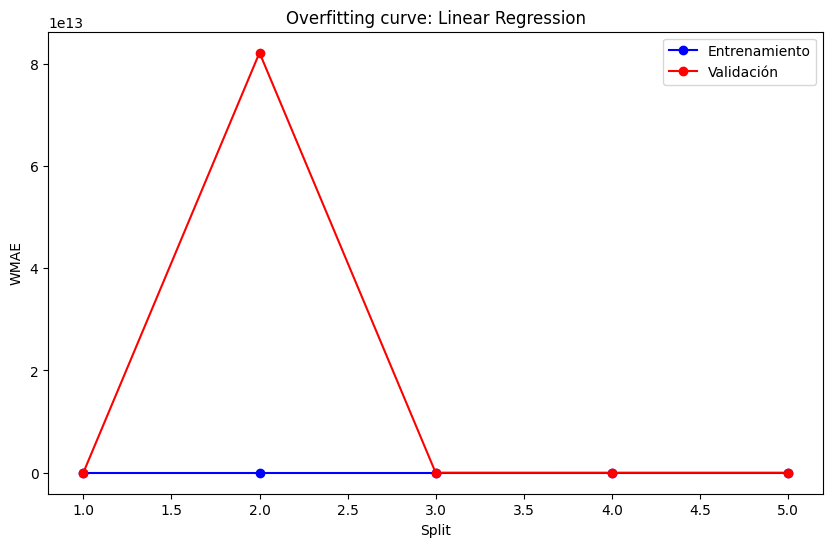

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13864
[LightGBM] [Info] Number of data points in the train set: 40531, number of used features: 138
[LightGBM] [Info] Start training from score 16341.820409
LGBM Regressor - Split 1 - WMAE entrenamiento: 1274.0991, WMAE validación: 1645.1282
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13987
[LightGBM] [Info] Number of data points in the train set: 81062, number of used features: 144
[LightGBM] [Info] Start training from score 16255.518852
LGBM Regressor - Split 2 - WMAE entrenamiento: 1333.4286, WMAE validación: 2734.0756
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016791 seconds.
You can set `force_col_wise=tr

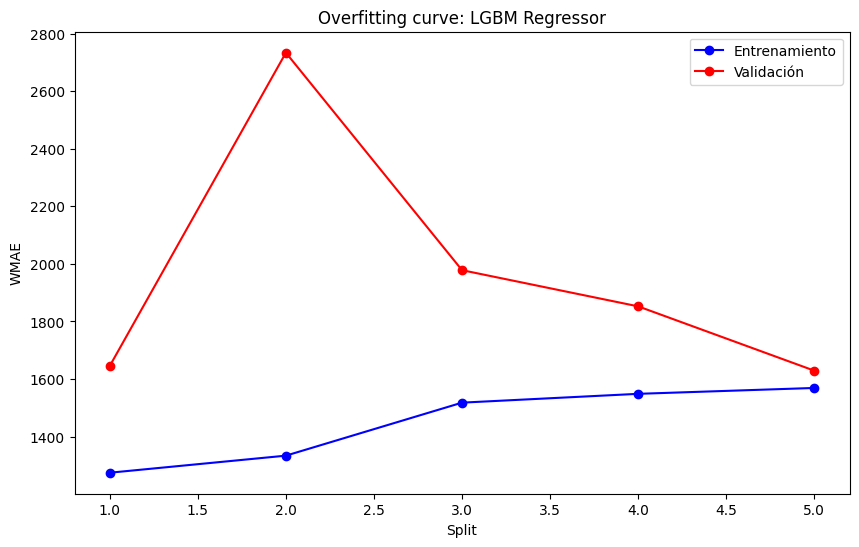

XGBoost Regressor - Split 1 - WMAE entrenamiento: 956.8984, WMAE validación: 1639.9023
XGBoost Regressor - Split 2 - WMAE entrenamiento: 1074.4328, WMAE validación: 2849.6512
XGBoost Regressor - Split 3 - WMAE entrenamiento: 1270.8052, WMAE validación: 2075.2472
XGBoost Regressor - Split 4 - WMAE entrenamiento: 1319.4561, WMAE validación: 1839.2309
XGBoost Regressor - Split 5 - WMAE entrenamiento: 1352.1079, WMAE validación: 1681.3949


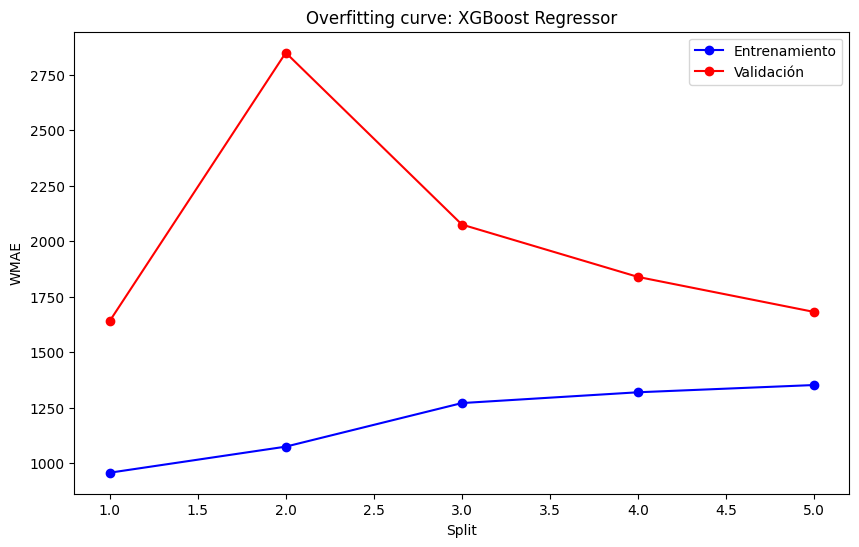


Mejor modelo: LGBM Regressor con WMAE promedio: 1967.7270


In [222]:
best_model, result_df = evaluate_models(models, X_train, y_train)

In [223]:
print(result_df)

               model  WMAE promedio
0  Linear Regression   1.643902e+13
1     LGBM Regressor   1.967727e+03
2  XGBoost Regressor   2.017085e+03


In [224]:
train_data #lag en Temperatura

,Store,Dept,Date,Weekly_Sales,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,...,l_3_w_3_median_Weekly_Sales,l_3_w_3_std_Weekly_Sales,l_3_w_3_max_Weekly_Sales,l_3_w_3_min_Weekly_Sales,l_3_w_4_sum_Weekly_Sales,l_3_w_4_mean_Weekly_Sales,l_3_w_4_median_Weekly_Sales,l_3_w_4_std_Weekly_Sales,l_3_w_4_max_Weekly_Sales,l_3_w_4_min_Weekly_Sales
170297,1,1,2011-03-18,20334.23,True,A,151315,62.76,3.488,0.00,...,41595.55,14269.476415,46039.49,19403.54,131963.08,32990.7700,33260.025,12832.106391,46039.49,19403.54
172913,6,33,2011-03-18,7910.22,True,A,202505,65.07,3.488,0.00,...,7807.00,851.952021,8761.85,7062.27,32792.13,8198.0325,8284.425,946.586624,9161.01,7062.27
171527,34,44,2011-03-18,2660.79,True,A,158114,55.58,3.495,0.00,...,2882.41,1281.574037,5054.12,2789.26,13692.25,3423.0625,2924.435,1089.777523,5054.12,2789.26
172663,6,32,2011-03-18,9877.12,True,A,202505,65.07,3.488,0.00,...,17041.66,5919.444858,18864.94,7822.84,57601.34,14400.3350,15456.780,4846.028600,18864.94,7822.84
170521,34,46,2011-03-18,19637.69,True,A,158114,55.58,3.495,0.00,...,16396.23,1316.788820,18068.43,15470.34,66094.75,16523.6875,16277.990,1102.189679,18068.43,15470.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420714,23,5,2012-10-26,35125.50,True,B,114533,50.56,3.917,4782.75,...,33103.72,5720.006996,41494.03,30564.08,133351.09,33337.7725,31833.900,5795.971820,41494.03,28189.26
420938,24,85,2012-10-26,1566.93,True,A,203819,55.16,4.071,10844.38,...,1684.78,257.890750,1907.98,1393.69,6561.83,1640.4575,1630.080,214.989963,1907.98,1393.69
420711,22,71,2012-10-26,3709.35,True,B,119557,57.58,3.917,7330.98,...,4632.70,149.798463,4680.82,4400.67,18749.37,4687.3425,4656.760,262.170679,5035.18,4400.67
420587,4,83,2012-10-26,8801.25,True,A,205863,63.64,3.514,1763.13,...,7921.32,725.611876,8748.21,7301.94,32755.98,8188.9950,8334.765,713.179737,8784.51,7301.94


In [225]:
best_model

LGBMRegressor()

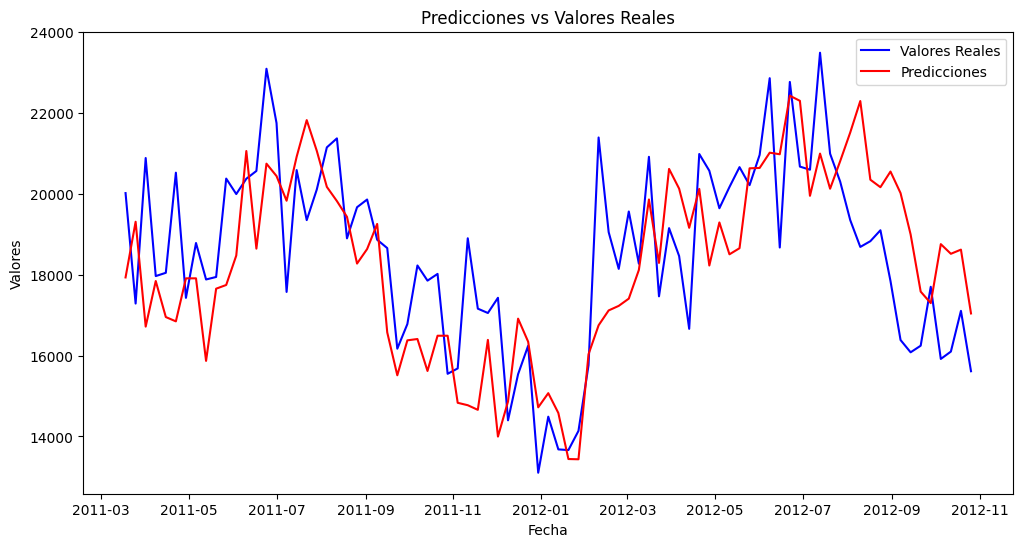

In [226]:
data_ = data.copy()
data_ = data_[(data_["Store"]==12) & (data_["Dept"]==10)]
data_ = data_[ data_ ["Date"] <=  "2012-10-26"]
X = preprocessor.transform(data_[input_cols])
y = data_[target_col[0]].values
y_pred = best_model.predict(X)
best_model
plt.figure(figsize=(12, 6))
plt.plot(data_["Date"], y, label='Valores Reales', color='blue')
plt.plot(data_["Date"], y_pred, label='Predicciones', color='red')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.legend()
plt.show()

In [227]:
len(best_model.feature_importances_)

156

In [228]:
len(pipeline.get_final_columns())

156

In [229]:
feature_importance_dict = {
    feature: importance
    for feature, importance in zip(pipeline.get_final_columns(), best_model.feature_importances_)
}

sorted_feature_importances = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))
sorted_feature_importances

{'Size': 351,
 'lag_0_Weekly_Sales': 325,
 'week_of_year': 223,
 'MarkDown3': 134,
 'Dept_18': 106,
 'Fuel_Price': 75,
 'Dept_92': 71,
 'l_0_w_3_sum_Weekly_Sales': 64,
 'MarkDown5': 62,
 'Dept_72': 61,
 'MarkDown4': 57,
 'l_0_w_3_std_Weekly_Sales': 55,
 'Temperature': 48,
 'l_0_w_3_median_Weekly_Sales': 47,
 'l_0_w_4_std_Weekly_Sales': 47,
 'MarkDown2': 44,
 'Dept_1': 44,
 'l_0_w_3_min_Weekly_Sales': 43,
 'l_3_w_4_min_Weekly_Sales': 43,
 'MarkDown1': 42,
 'l_0_w_4_min_Weekly_Sales': 42,
 'Dept_5': 40,
 'l_0_w_4_max_Weekly_Sales': 39,
 'Dept_38': 37,
 'lag_1_Weekly_Sales': 35,
 'Dept_90': 31,
 'Type_A': 30,
 'month_4': 30,
 'l_0_w_4_median_Weekly_Sales': 29,
 'l_0_w_4_sum_Weekly_Sales': 28,
 'l_1_w_3_std_Weekly_Sales': 28,
 'l_2_w_3_std_Weekly_Sales': 28,
 'l_3_w_3_min_Weekly_Sales': 25,
 'l_0_w_3_max_Weekly_Sales': 24,
 'lag_3_Weekly_Sales': 24,
 'Dept_87': 24,
 'l_1_w_4_std_Weekly_Sales': 22,
 'year': 21,
 'month_11': 21,
 'Dept_7': 19,
 'Dept_95': 19,
 'l_2_w_4_std_Weekly_Sales': 18,

In [230]:
test_df

,Store,Dept,Date,Weekly_Sales,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,...,l_3_w_3_median_Weekly_Sales,l_3_w_3_std_Weekly_Sales,l_3_w_3_max_Weekly_Sales,l_3_w_3_min_Weekly_Sales,l_3_w_4_sum_Weekly_Sales,l_3_w_4_mean_Weekly_Sales,l_3_w_4_median_Weekly_Sales,l_3_w_4_std_Weekly_Sales,l_3_w_4_max_Weekly_Sales,l_3_w_4_min_Weekly_Sales
422110,19,44,2012-11-02,0.0,False,A,203819,46.81,3.970,11686.96,...,6096.83,1018.096004,6880.89,4861.44,23288.72,5822.1800,5773.195,867.595624,6880.89,4861.44
422839,39,29,2012-11-02,0.0,False,A,184109,59.87,3.386,9892.40,...,4050.82,421.554242,4285.27,3466.69,16931.68,4232.9200,4168.045,689.393334,5128.90,3466.69
424302,27,13,2012-11-02,0.0,False,A,204184,54.44,3.970,13125.35,...,55329.88,728.892455,56359.38,54950.79,221633.71,55408.4275,55161.770,656.237896,56359.38,54950.79
421765,9,85,2012-11-02,0.0,False,B,125833,56.26,3.386,2291.26,...,924.25,79.905614,942.85,796.09,3828.73,957.1825,933.550,153.464015,1165.54,796.09
422018,9,22,2012-11-02,0.0,False,B,125833,56.26,3.386,2291.26,...,4125.81,1292.859972,5908.60,3395.26,17064.01,4266.0025,3880.075,1136.510815,5908.60,3395.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534619,10,74,2013-07-26,0.0,False,B,126512,83.32,3.865,1221.15,...,40184.26,1985.279540,41911.56,37951.73,160305.38,40076.3450,40221.045,1625.483051,41911.56,37951.73
536195,26,32,2013-07-26,0.0,False,A,152513,63.07,3.879,538.78,...,4805.56,849.073129,5797.88,4108.30,19154.92,4788.7300,4624.370,730.537875,5797.88,4108.30
534621,10,72,2013-07-26,0.0,False,B,126512,83.32,3.865,1221.15,...,100464.25,5779.359253,107949.41,96579.10,410492.15,102623.0375,102981.820,5093.564295,107949.41,96579.10
536181,26,52,2013-07-26,0.0,False,A,152513,63.07,3.879,538.78,...,1361.72,137.168093,1439.61,1172.86,5281.07,1320.2675,1334.300,112.352330,1439.61,1172.86


In [231]:
test_df

,Store,Dept,Date,Weekly_Sales,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,...,l_3_w_3_median_Weekly_Sales,l_3_w_3_std_Weekly_Sales,l_3_w_3_max_Weekly_Sales,l_3_w_3_min_Weekly_Sales,l_3_w_4_sum_Weekly_Sales,l_3_w_4_mean_Weekly_Sales,l_3_w_4_median_Weekly_Sales,l_3_w_4_std_Weekly_Sales,l_3_w_4_max_Weekly_Sales,l_3_w_4_min_Weekly_Sales
422110,19,44,2012-11-02,0.0,False,A,203819,46.81,3.970,11686.96,...,6096.83,1018.096004,6880.89,4861.44,23288.72,5822.1800,5773.195,867.595624,6880.89,4861.44
422839,39,29,2012-11-02,0.0,False,A,184109,59.87,3.386,9892.40,...,4050.82,421.554242,4285.27,3466.69,16931.68,4232.9200,4168.045,689.393334,5128.90,3466.69
424302,27,13,2012-11-02,0.0,False,A,204184,54.44,3.970,13125.35,...,55329.88,728.892455,56359.38,54950.79,221633.71,55408.4275,55161.770,656.237896,56359.38,54950.79
421765,9,85,2012-11-02,0.0,False,B,125833,56.26,3.386,2291.26,...,924.25,79.905614,942.85,796.09,3828.73,957.1825,933.550,153.464015,1165.54,796.09
422018,9,22,2012-11-02,0.0,False,B,125833,56.26,3.386,2291.26,...,4125.81,1292.859972,5908.60,3395.26,17064.01,4266.0025,3880.075,1136.510815,5908.60,3395.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534619,10,74,2013-07-26,0.0,False,B,126512,83.32,3.865,1221.15,...,40184.26,1985.279540,41911.56,37951.73,160305.38,40076.3450,40221.045,1625.483051,41911.56,37951.73
536195,26,32,2013-07-26,0.0,False,A,152513,63.07,3.879,538.78,...,4805.56,849.073129,5797.88,4108.30,19154.92,4788.7300,4624.370,730.537875,5797.88,4108.30
534621,10,72,2013-07-26,0.0,False,B,126512,83.32,3.865,1221.15,...,100464.25,5779.359253,107949.41,96579.10,410492.15,102623.0375,102981.820,5093.564295,107949.41,96579.10
536181,26,52,2013-07-26,0.0,False,A,152513,63.07,3.879,538.78,...,1361.72,137.168093,1439.61,1172.86,5281.07,1320.2675,1334.300,112.352330,1439.61,1172.86


In [232]:
summit_df = pd.read_csv("walmart_dataset/test.csv", date_format=False)

In [233]:
summit_df.drop("IsHoliday", axis=1, inplace=True)

In [234]:
summit_df

,Store,Dept,Date
0,1,1,2012-11-02
1,1,1,2012-11-09
2,1,1,2012-11-16
3,1,1,2012-11-23
4,1,1,2012-11-30
...,...,...,...
115059,45,98,2013-06-28
115060,45,98,2013-07-05
115061,45,98,2013-07-12
115062,45,98,2013-07-19


In [235]:
summit_df["Date"] = pd.to_datetime(summit_df["Date"],  yearfirst=True)

In [236]:
summit_df

,Store,Dept,Date
0,1,1,2012-11-02
1,1,1,2012-11-09
2,1,1,2012-11-16
3,1,1,2012-11-23
4,1,1,2012-11-30
...,...,...,...
115059,45,98,2013-06-28
115060,45,98,2013-07-05
115061,45,98,2013-07-12
115062,45,98,2013-07-19


In [237]:
summit_df = summit_df.merge(test_df, how="left", on=["Store", "Dept", "Date"])

In [238]:
summit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        115064 non-null  int64         
 1   Dept                         115064 non-null  int64         
 2   Date                         115064 non-null  datetime64[ns]
 3   Weekly_Sales                 113465 non-null  float64       
 4   IsTrain                      113465 non-null  object        
 5   Type                         113465 non-null  object        
 6   Size                         113465 non-null  float64       
 7   Temperature                  113465 non-null  float64       
 8   Fuel_Price                   113465 non-null  float64       
 9   MarkDown1                    113465 non-null  float64       
 10  MarkDown2                    113465 non-null  float64       
 11  MarkDown3                 

In [239]:
X_summit = preprocessor.transform(summit_df[input_cols])
print("Shape of ", X_summit.shape)
y_summit_pred = best_model.predict(X_summit)

C:\Users\Admin\AppData\Local\pypoetry\Cache\virtualenvs\serie-de-tiempo-U4LVjEKB-py3.12\Lib\site-packages\sklearn\compose\_column_transformer.py:764: FutureWarning:

The output of the 'num' transformer for column 'week_of_year' has dtype UInt32 and uses pandas.NA to represent null values. Storing this output in a numpy array can cause errors in downstream scikit-learn estimators, and inefficiencies. Starting with scikit-learn version 1.6, this will raise a ValueError. To avoid this problem you can (i) store the output in a pandas DataFrame by using ColumnTransformer.set_output(transform='pandas') or (ii) modify the input data or the 'num' transformer to avoid the presence of pandas.NA (for example by using pandas.DataFrame.astype).



Shape of  (115064, 156)


TypeError: float() argument must be a string or a real number, not 'NAType'

In [83]:
summit_df["Weekly_Sales"] = y_summit_pred

In [84]:
summit_df['Id'] = summit_df.apply(lambda row: f"{row['Store']}_{row['Dept']}_{row['Date'].strftime('%Y-%m-%d')}", axis=1)

In [85]:
summit_df

,Store,Dept,Date,Weekly_Sales,IsTrain,Type,Size,Temperature,Fuel_Price,MarkDown1,...,l_3_w_3_std_Weekly_Sales,l_3_w_3_max_Weekly_Sales,l_3_w_3_min_Weekly_Sales,l_3_w_4_sum_Weekly_Sales,l_3_w_4_mean_Weekly_Sales,l_3_w_4_median_Weekly_Sales,l_3_w_4_std_Weekly_Sales,l_3_w_4_max_Weekly_Sales,l_3_w_4_min_Weekly_Sales,Id
0,1,1,2012-11-02,36663.090136,False,A,151315.0,55.32,3.386,6766.44,...,2370.504125,23077.55,18337.68,80072.11,20018.0275,19567.630,2411.918473,23077.55,17859.30,1_1_2012-11-02
1,1,1,2012-11-09,21577.046433,False,A,151315.0,61.24,3.314,11421.32,...,1402.231321,23351.80,20797.58,85564.61,21391.1525,21937.565,2335.529759,23351.80,18337.68,1_1_2012-11-09
2,1,1,2012-11-16,21511.230884,False,A,151315.0,52.92,3.252,9696.28,...,4831.611156,31579.90,23077.55,98806.83,24701.7075,23214.675,4726.234634,31579.90,20797.58,1_1_2012-11-16
3,1,1,2012-11-23,21868.792942,False,A,151315.0,56.23,3.211,883.59,...,8267.160711,39886.06,23351.80,117895.31,29473.8275,27465.850,7984.186737,39886.06,23077.55,1_1_2012-11-23
4,1,1,2012-11-30,24776.478171,False,A,151315.0,52.34,3.207,2460.03,...,10680.559715,39886.06,18689.54,113507.30,28376.8250,27465.850,9341.958158,39886.06,18689.54,1_1_2012-11-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,772.111845,False,B,118221.0,76.05,3.639,4842.29,...,80.577233,874.64,713.50,3129.52,782.3800,770.690,70.249079,874.64,713.50,45_98_2013-06-28
115060,45,98,2013-07-05,876.978960,False,B,118221.0,77.50,3.614,9090.48,...,88.229574,874.64,713.50,3240.43,810.1075,826.145,72.655671,874.64,713.50,45_98_2013-07-05
115061,45,98,2013-07-12,670.765014,False,B,118221.0,79.37,3.614,3789.94,...,117.824028,856.35,622.62,3067.11,766.7775,784.925,120.107491,874.64,622.62,45_98_2013-07-12
115062,45,98,2013-07-19,771.563019,False,B,118221.0,82.84,3.737,2961.49,...,120.235680,856.35,622.62,2882.99,720.7475,702.010,98.290848,856.35,622.62,45_98_2013-07-19


In [86]:
summit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Store                        115064 non-null  int64         
 1   Dept                         115064 non-null  int64         
 2   Date                         115064 non-null  datetime64[ns]
 3   Weekly_Sales                 115064 non-null  float64       
 4   IsTrain                      113465 non-null  object        
 5   Type                         113465 non-null  object        
 6   Size                         113465 non-null  float64       
 7   Temperature                  113465 non-null  float64       
 8   Fuel_Price                   113465 non-null  float64       
 9   MarkDown1                    113465 non-null  float64       
 10  MarkDown2                    113465 non-null  float64       
 11  MarkDown3                 

In [87]:
sampleSubmission_df = pd.read_csv("walmart_dataset/sampleSubmission.csv", date_format=False)

In [88]:
sampleSubmission_df.shape

(115064, 2)

In [89]:
sampleSubmission_df

,Id,Weekly_Sales
0,1_1_2012-11-02,0
1,1_1_2012-11-09,0
2,1_1_2012-11-16,0
3,1_1_2012-11-23,0
4,1_1_2012-11-30,0
...,...,...
115059,45_98_2013-06-28,0
115060,45_98_2013-07-05,0
115061,45_98_2013-07-12,0
115062,45_98_2013-07-19,0


In [90]:
sampleSubmission_df.drop("Weekly_Sales", axis=1, inplace=True)

In [91]:
sampleSubmission_df = sampleSubmission_df.merge(summit_df, how="left", on=["Id"])

In [92]:
sampleSubmission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Id                           115064 non-null  object        
 1   Store                        115064 non-null  int64         
 2   Dept                         115064 non-null  int64         
 3   Date                         115064 non-null  datetime64[ns]
 4   Weekly_Sales                 115064 non-null  float64       
 5   IsTrain                      113465 non-null  object        
 6   Type                         113465 non-null  object        
 7   Size                         113465 non-null  float64       
 8   Temperature                  113465 non-null  float64       
 9   Fuel_Price                   113465 non-null  float64       
 10  MarkDown1                    113465 non-null  float64       
 11  MarkDown2                 

In [93]:
kagle = sampleSubmission_df[["Id", "Weekly_Sales"]].copy()

In [94]:
kagle

,Id,Weekly_Sales
0,1_1_2012-11-02,36663.090136
1,1_1_2012-11-09,21577.046433
2,1_1_2012-11-16,21511.230884
3,1_1_2012-11-23,21868.792942
4,1_1_2012-11-30,24776.478171
...,...,...
115059,45_98_2013-06-28,772.111845
115060,45_98_2013-07-05,876.978960
115061,45_98_2013-07-12,670.765014
115062,45_98_2013-07-19,771.563019


In [95]:
kagle.to_csv("summit2.csv", index=False)

In [ ]:
#hacer correlacion entre variables predictoras
#distancias semanas a la proxima
#distancia semana de la ultima proximidad
# univariados, bivariados

In [241]:
import shap
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)


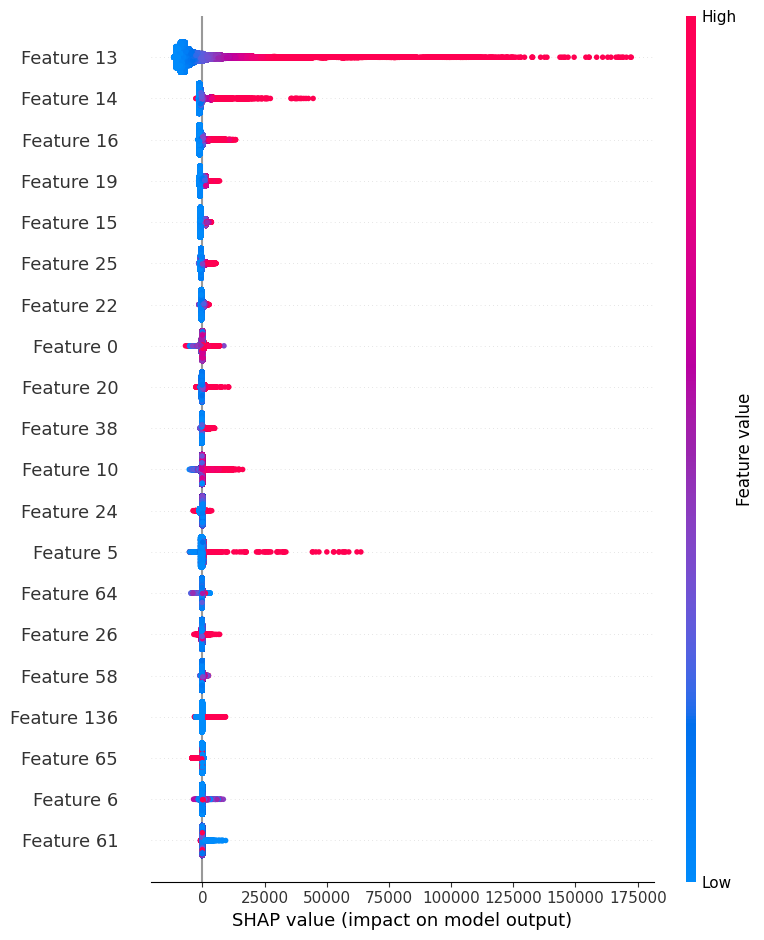

In [247]:
shap.summary_plot(shap_values, X_train, show=False)

In [242]:
shap_values

array([[ 279.06224775,   14.68279274,   42.60199914, ...,   -7.29296697,
         -11.32523855,    0.        ],
       [  39.90381298,   13.05608834,   72.7068837 , ...,   -2.26484007,
          -6.11403628,    0.        ],
       [  77.88545386,   11.38486384,   65.12430513, ...,   -2.26484007,
          -6.11403628,    0.        ],
       ...,
       [ -72.62739012,    8.94156557,  -71.15855479, ...,   35.28401829,
          -5.42578424,    0.        ],
       [ 494.5910663 ,    6.09298541,   55.11422896, ...,   37.59092024,
          -5.34628565,    0.        ],
       [1004.16780103,   45.37816523, -138.19769826, ...,  148.97848111,
         -16.35241527,    0.        ]])

In [ ]:
shap_values = explainer.shap_values(model["pipe1"].transform(x_train))